In [1]:
class CFG:
  dataset='./dataset/polarization_ds.csv'
  train_df='./dataset/media_split/train.csv'
  valid_df='./dataset/media_split/valid.csv'
  test_df='./dataset/media_split/test.csv'
  target_cols=['left', 'center', 'right'] # 'bias_text'
  classes=3
  model='bert-base-cased'
  embedd_dim=768
  criterion = 'mse' # ['crossentropy', 'mse', 'l1', 'focal']
  main_metric = 'f1_macro'
  model_file = './models/best_bert_base.pt'
  triplet_pretrain = False
  emotion_pretrain = False
  triplet_model = './models/bert_base_triplet.pt'
  emotion_model = '../emotion_detection/models/ed_best_bert_base.pt'
  # just use it
  apex=True
  gradient_checkpointing=True
  num_cycles=0.5
  num_warmup_steps=0
  epochs=5
  encoder_lr=2e-5
  decoder_lr=2e-5
  min_lr=1e-6
  eps=1e-6
  betas=(0.9, 0.999)
  batch_size=128
  max_len=512
  weight_decay=0.01
  # gradient_accumulation_steps=1
  max_grad_norm=1000
  seed=0
  scheduler='cosine' # ['linear', 'cosine']
  batch_scheduler=True
  #
  collab=False

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
if CFG.collab:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  os.chdir('/content/drive/MyDrive/lab/bert_finetune')

# Load libraries and data

In [4]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

from tqdm import tqdm
import gc

In [5]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available(): # для GPU отдельный seed
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(CFG.seed)
# есть стохастические операции на GPU
# сделаем их детерминированными для воспроизводимости
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [6]:
CFG.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CFG.tokenizer = AutoTokenizer.from_pretrained(CFG.model)

In [7]:
df = pd.read_csv(CFG.dataset, index_col='id')
train_df = pd.read_csv(CFG.train_df)
valid_df = pd.read_csv(CFG.valid_df)

In [8]:
df.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text
id,,,,,,,,,,,
wzYhj24VaSbhhr8T,sexual_misconduct,New York Post,2.0,https://nypost.com/2020/05/03/two-more-people-...,Two more people back parts of Tara Reade’s cla...,2020-05-03,NaN,Two more people corroborated some of Tara Read...,Two more people corroborated some of Tara Read...,www.nypost.com,right
pcgmZXUEXb0xWWB1,marijuana_legalization,Washington Times,2.0,http://www.washingtontimes.com/news/2014/apr/2...,Colorado lawmakers set limits on pot edibles p...,2014-04-21,Valerie Richardson,DENVER — The Mile High City was jammed with po...,DENVER — The Mile High City was jammed with po...,www.washingtontimes.com,right
oYxUHzLvAtQhGoXk,foreign_policy,TheBlaze.com,2.0,https://www.theblaze.com/news/2018/11/11/trump...,"Trump, world leaders, mark 100-year WWI annive...",2018-11-11,Teri Webster,President Donald Trump and dozens of world lea...,President Donald Trump and dozens of world lea...,www.theblaze.com,right
EHAhlgvwQ8U2ZvGB,race_and_racism,Matt Welch,2.0,http://reason.com/blog/2014/01/30/its-not-just...,It’s Not Just MSNBC Making Flip Assumptions Ab...,2014-01-30,"Josh Blackman, Scott Shackford, Shikha Dalmia,...","Last night , the official Twitter feed of MSNB...","Last night, the official Twitter feed of MSNBC...",www.reason.com,right
JD0fSIsxc4p1DuDe,china,NPR Online News,1.0,https://www.npr.org/sections/goatsandsoda/2019...,The Global Stories Of 2019 That You Probably M...,2019-12-28,Marc Silver,"Sure , everybody thinks it 's great when a sto...",The Global Stories Of 2019 That You Probably M...,www.npr.org,center


In [9]:
df['topic'].nunique()

108

In [10]:
df['topic'].unique()

array(['sexual_misconduct', 'marijuana_legalization', 'foreign_policy',
       'race_and_racism', 'china', 'trade', 'immigration', 'politics',
       'gun_control_and_gun_rights', 'us_congress', 'coronavirus',
       'healthcare', 'lgbt_rights', 'republican_party', 'white_house',
       'us_house', 'defense', 'nsa', 'media_bias', 'abortion',
       'economy_and_jobs', 'elections', 'education', 'world', 'terrorism',
       'culture', 'middle_east', 'supreme_court', 'russia', 'free_speech',
       'campaign_finance', 'us_senate', 'economic_policy', 'north_korea',
       'us_military', 'general_news', 'israel', 'fiscal_cliff',
       'violence_in_america', 'cybersecurity', 'justice_department',
       'national_security', 'civil_rights', 'great_britain', 'fbi',
       'impeachment', 'obesity_and_malnutrition', 'role_of_government',
       'voting_rights_and_voter_fraud', 'social_security', 'holidays',
       'isis', 'state_department', 'religion_and_faith', 'taxes',
       'banking_and_fi

In [11]:
import matplotlib.pyplot as plt

In [37]:
cv = df[df['topic'] == 'coronavirus']
el = df[df['topic'] == 'elections']
tec = df[df['topic'] == 'technology']

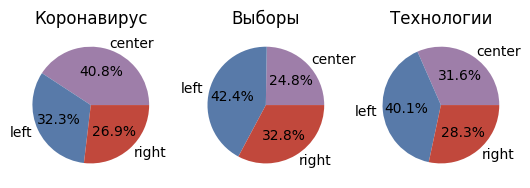

In [40]:
fig, ax = plt.subplots(1, 3)
tmp = cv['bias_text'].value_counts().sort_index()
ax[0].pie(tmp, labels=tmp.index, autopct='%1.1f%%', colors=['#9e7ea9', '#587aa9', '#c1483c'])
ax[0].set_title('Коронавирус')

tmp = el['bias_text'].value_counts().sort_index()
ax[1].pie(tmp, labels=tmp.index, autopct='%1.1f%%', colors=['#9e7ea9', '#587aa9', '#c1483c'])
ax[1].set_title('Выборы')

tmp = tec['bias_text'].value_counts().sort_index()
ax[2].pie(tmp, labels=tmp.index, autopct='%1.1f%%', colors=['#9e7ea9', '#587aa9', '#c1483c'])
ax[2].set_title('Технологии')

fig.savefig('distr.png', dpi=300)
fig.show()

In [9]:
target = (df['bias_text'] == 'center') + (df['bias_text'] == 'right') * 2
df['bias_text'] = target

In [10]:
df['left'] = (df['bias_text'] == 0).astype(float)
df['center'] = (df['bias_text'] == 1).astype(float)
df['right'] = (df['bias_text'] == 2).astype(float)

In [11]:
train_df = df.loc[train_df['ID']]
valid_df = df.loc[valid_df['ID']]

In [12]:
train_df.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,left,center,right
id,,,,,,,,,,,,,,
zl7kc7EmAyIdUMIo,immigration,National Review,2.0,https://www.nationalreview.com/2018/12/governm...,"Shutdown Theater, Again",2018-12-12,"Kevin D. Williamson, Kyle Smith, Andrew C. Mcc...",President Trump and Senate Minority Leader Chu...,President Trump and Senate Minority Leader Chu...,www.nationalreview.com,2,0.0,0.0,1.0
xpbjYTJYPdlw6HmJ,culture,Yahoo! The 360,1.0,https://news.yahoo.com/can-the-developing-worl...,Can the developing world endure the coronavirus?,2020-06-30,Mike Bebernes,“ The 360 ” shows you diverse perspectives on ...,“The 360” shows you diverse perspectives on th...,www.news.yahoo.com,1,0.0,1.0,0.0
k4SGI3GXarnz5dJl,elections,Politico,0.0,http://www.politico.com/story/2016/07/bernie-s...,Sanders’ California supporters can’t quite say...,2016-07-02,"Daniel Strauss, Henry C. Jackson, Nick Gass",LOS ANGELES — Actress Rosario Dawson took the ...,LOS ANGELES — Actress Rosario Dawson took the ...,www.politico.com,0,1.0,0.0,0.0
0jIpietfnrPRGHKQ,white_house,Business Insider,1.0,https://www.businessinsider.com/trump-distance...,Trump says he doesn't know if Rudy Giuliani is...,2019-10-11,Sonam Sheth,President Donald Trump said on Friday that he ...,President Donald Trump said on Friday that he ...,www.businessinsider.com,1,0.0,1.0,0.0
zMlSt7dyJvanHqJq,politics,CNN (Web News),0.0,http://www.cnn.com/2017/01/20/politics/donald-...,Trump's historic moment arrives,2017-01-20,Stephen Collinson,Washington ( CNN ) Donald Trump became the 45t...,Washington (CNN) Donald Trump became the 45th ...,www.cnn.com,0,1.0,0.0,0.0


# Dataset

In [13]:
class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = (df['title'] + ' ' + df['content']).values
        self.labels = df[cfg.target_cols].values

    def __len__(self):
        return len(self.texts)

    def get_text(self, idx):
        # tokenization
        inputs = self.cfg.tokenizer.encode_plus(
            self.texts[idx], 
            return_tensors=None, 
            add_special_tokens=True, 
            max_length=CFG.max_len,
            pad_to_max_length=True,
            truncation=True
        )
        for k, v in inputs.items():
            inputs[k] = torch.tensor(v, dtype=torch.long)
        return inputs
    
    def get_labels(self, idx):
        if CFG.criterion != 'crossentropy' and CFG.criterion != 'focal':
           return torch.tensor(self.labels[idx], dtype=torch.float)
        return torch.tensor(self.labels[idx]).type(torch.LongTensor)

    def __getitem__(self, idx):
        inputs = self.get_text(idx)
        label = self.get_labels(idx)
        return inputs, label

def collate(inputs):
		# reduce sequence length
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# Model

In [14]:
class TransformerModel(nn.Module):

    def __init__(self):
        super(TransformerModel, self).__init__()

        self.model = AutoModel.from_pretrained(CFG.model)
        if CFG.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()
        self.clf =  nn.Linear(CFG.embedd_dim, CFG.classes)
        if not CFG.criterion == 'crossentropy':
            self.sm = nn.Softmax(dim=-1)
        torch.nn.init.xavier_uniform_(self.clf.weight)

    def forward(self, input_id, mask):
        # sequence has [CLF] token in the beginning
        # bert() returns first vector as pooling of sentence
        _, x = self.model(input_ids= input_id, attention_mask=mask, return_dict=False)
        out = self.clf(x)
        if not CFG.criterion == 'crossentropy':
            return self.sm(out)
        return out

# Train loop, metrics and other

In [15]:
from sklearn.metrics import f1_score, accuracy_score

In [16]:
def calculate_metrics(y, pred):
  y = torch.argmax(y, dim=1)
  pred = torch.argmax(pred, dim=1)
  f1 = f1_score(y, pred, average='macro')
  acc = accuracy_score(y, pred)
  return {'f1_macro': f1, 'acc': acc}

In [17]:
def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters

def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.scheduler == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
        )
    elif cfg.scheduler == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
        )
    return scheduler

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = torch.exp(logpt)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.reduction == 'mean': 
          return loss.mean()
        elif self.reduction == 'sum':
          return loss.sum()
        else:
          raise NotImplementedError(f'Not implemented reduction: {self.reduction}')

In [19]:
train_ds = TrainDataset(CFG, train_df)
valid_ds = TrainDataset(CFG, valid_df)

In [20]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=CFG.batch_size, shuffle=False)

In [21]:
model = TransformerModel()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
if CFG.criterion == 'crossentropy':
  criterion = nn.CrossEntropyLoss()
elif CFG.criterion == 'mse':
  criterion = nn.MSELoss()
elif CFG.criterion == 'l1':
  criterion = nn.SmoothL1Loss()
elif CFG.criterion == 'focal':
  criterion = FocalLoss(5)
else:
  raise NotImplementedError('Change loss')

In [23]:
#optimizer_parameters = get_optimizer_params(model,
#                                            encoder_lr=CFG.encoder_lr, 
#                                            decoder_lr=CFG.decoder_lr,
#                                            weight_decay=CFG.weight_decay)
#optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)

In [24]:
optimizer = AdamW(model.parameters(), lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)

In [25]:
num_train_steps = int(len(train_df) / CFG.batch_size * CFG.epochs)
scheduler = get_scheduler(CFG, optimizer, num_train_steps)

In [26]:
model.to(CFG.device)
criterion.to(CFG.device)

MSELoss()

In [27]:
def train_loop(model, optimizer, criterion, train_loader, valid_loader, epochs, scheduler):
  best_score = 0
  # multiplies gradient so it won't vanish (torch use float16)
  scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
  for e in range(epochs):
    # train
    model.train()
    train_loss = []
    for inputs, labels in tqdm(train_loader):
      inputs = collate(inputs)
      # move inputs to device
      mask = inputs['attention_mask'].to(CFG.device)
      input_id = inputs['input_ids'].squeeze(1).to(CFG.device)
      labels = labels.to(CFG.device)
      # forward
      with torch.cuda.amp.autocast(enabled=CFG.apex):
        y_preds = model(input_id, mask)
        loss = criterion(y_preds, labels)
      # calculate loss
      train_loss.append(loss.detach().cpu().item())

      optimizer.zero_grad()
      # loss.backward()
      scaler.scale(loss).backward()
      # gradient clipping
      grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
      scaler.step(optimizer)
      scaler.update()
      # optimizer.step()
      if CFG.batch_scheduler:
          scheduler.step()
    train_loss = np.mean(train_loss)
    # valid
    model.eval()
    with torch.no_grad():
      valid_loss = []
      preds = []
      y = []
      for inputs, labels in valid_loader:
        inputs = collate(inputs)
        # move inputs to device
        mask = inputs['attention_mask'].to(CFG.device)
        input_id = inputs['input_ids'].squeeze(1).to(CFG.device)
        labels = labels.to(CFG.device)
        # forward
        # with torch.cuda.amp.autocast(enabled=CFG.apex):
        y_preds = model(input_id, mask)
        loss = criterion(y_preds, labels)
        preds.append(y_preds.detach().cpu())
        y.append(labels.detach().cpu())
        # calculate loss
        valid_loss.append(loss.detach().cpu().item())
    valid_loss = np.mean(valid_loss)
    preds = torch.concat(preds, dim=0)
    y = torch.concat(y, dim=0)
    metrics = calculate_metrics(y, preds)
    # save best model
    if best_score < metrics[CFG.main_metric]:
      torch.save(model.state_dict(), CFG.model_file) 
      best_score = metrics[CFG.main_metric]
    print(f'EPOCH {e + 1}:, train_loss = {train_loss}, valid_loss = {valid_loss}', *[f'{name} = {value}' for name, value in metrics.items()])
    

In [28]:
from collections import OrderedDict

In [29]:
if CFG.triplet_pretrain:
    model.load_state_dict(torch.load(CFG.triplet_model))
elif CFG.emotion_pretrain:
    sd = torch.load(CFG.emotion_model)
    new_sd = OrderedDict()
    for param_name in sd:
        if param_name[:6] == 'model.':
            new_sd[param_name[6:]] = sd[param_name]
    model.model.load_state_dict(new_sd)

In [30]:
train_loop(model, optimizer, criterion, train_loader, valid_loader, CFG.epochs, scheduler)

100%|██████████| 208/208 [07:38<00:00,  2.20s/it]


EPOCH 1:, train_loss = 0.1527837851944451, valid_loss = 0.36368649727419805 f1_macro = 0.2029352567181295 acc = 0.21561969439728354


100%|██████████| 208/208 [07:40<00:00,  2.22s/it]


EPOCH 2:, train_loss = 0.08556886692531407, valid_loss = 0.39262086309884725 f1_macro = 0.18004512900816474 acc = 0.22241086587436332


100%|██████████| 208/208 [07:41<00:00,  2.22s/it]


EPOCH 3:, train_loss = 0.06640793848782778, valid_loss = 0.4143711093224977 f1_macro = 0.18182793745576628 acc = 0.2067062818336163


100%|██████████| 208/208 [07:40<00:00,  2.21s/it]


EPOCH 4:, train_loss = 0.05731172184459865, valid_loss = 0.41173433943798665 f1_macro = 0.1878807837594866 acc = 0.21901528013582344


100%|██████████| 208/208 [07:40<00:00,  2.21s/it]


EPOCH 5:, train_loss = 0.053420204982663005, valid_loss = 0.4173531281320672 f1_macro = 0.18624816756275142 acc = 0.21477079796264856


# Test

In [31]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
      test_loss = []
      preds = []
      y = []
      for step, (inputs, labels) in enumerate(test_loader):
        inputs = collate(inputs)
        # move inputs to device
        mask = inputs['attention_mask'].to(CFG.device)
        input_id = inputs['input_ids'].squeeze(1).to(CFG.device)
        labels = labels.to(CFG.device)
        # forward
        # with torch.cuda.amp.autocast(enabled=CFG.apex):
        y_preds = model(input_id, mask)
        loss = criterion(y_preds, labels)
        preds.append(y_preds.detach().cpu())
        y.append(labels.detach().cpu())
        # calculate loss
        test_loss.append(loss.detach().cpu().item())
    test_loss = np.mean(test_loss)
    preds = torch.concat(preds, dim=0)
    y = torch.concat(y, dim=0)
    metrics = calculate_metrics(y, preds)

    print(f'Test metrics: test_loss={test_loss}', *[f'{name} = {value}' for name, value in metrics.items()])

In [32]:
model.load_state_dict(torch.load(CFG.model_file))

<All keys matched successfully>

In [33]:
test_df = pd.read_csv(CFG.test_df)
test_df = df.loc[test_df['ID']]
test_ds = TrainDataset(CFG, test_df)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False)

In [34]:
CFG.batch_size

128

In [35]:
test(model, valid_loader)

Test metrics: test_loss=0.36368649727419805 f1_macro = 0.2029352567181295 acc = 0.21561969439728354


In [36]:
test(model, test_loader)

Test metrics: test_loss=0.22532123462720352 f1_macro = 0.41957019815261626 acc = 0.4553846153846154
